Found 3 FITS files
  TIC ID: 267263253
  Sector: 1
  Data points: 18277
  Time range: 1325.30 to 1353.18 days
  Flux range: 33577.29 to 34308.96
  Best period: 1.3675 days
  Max power: 0.0836


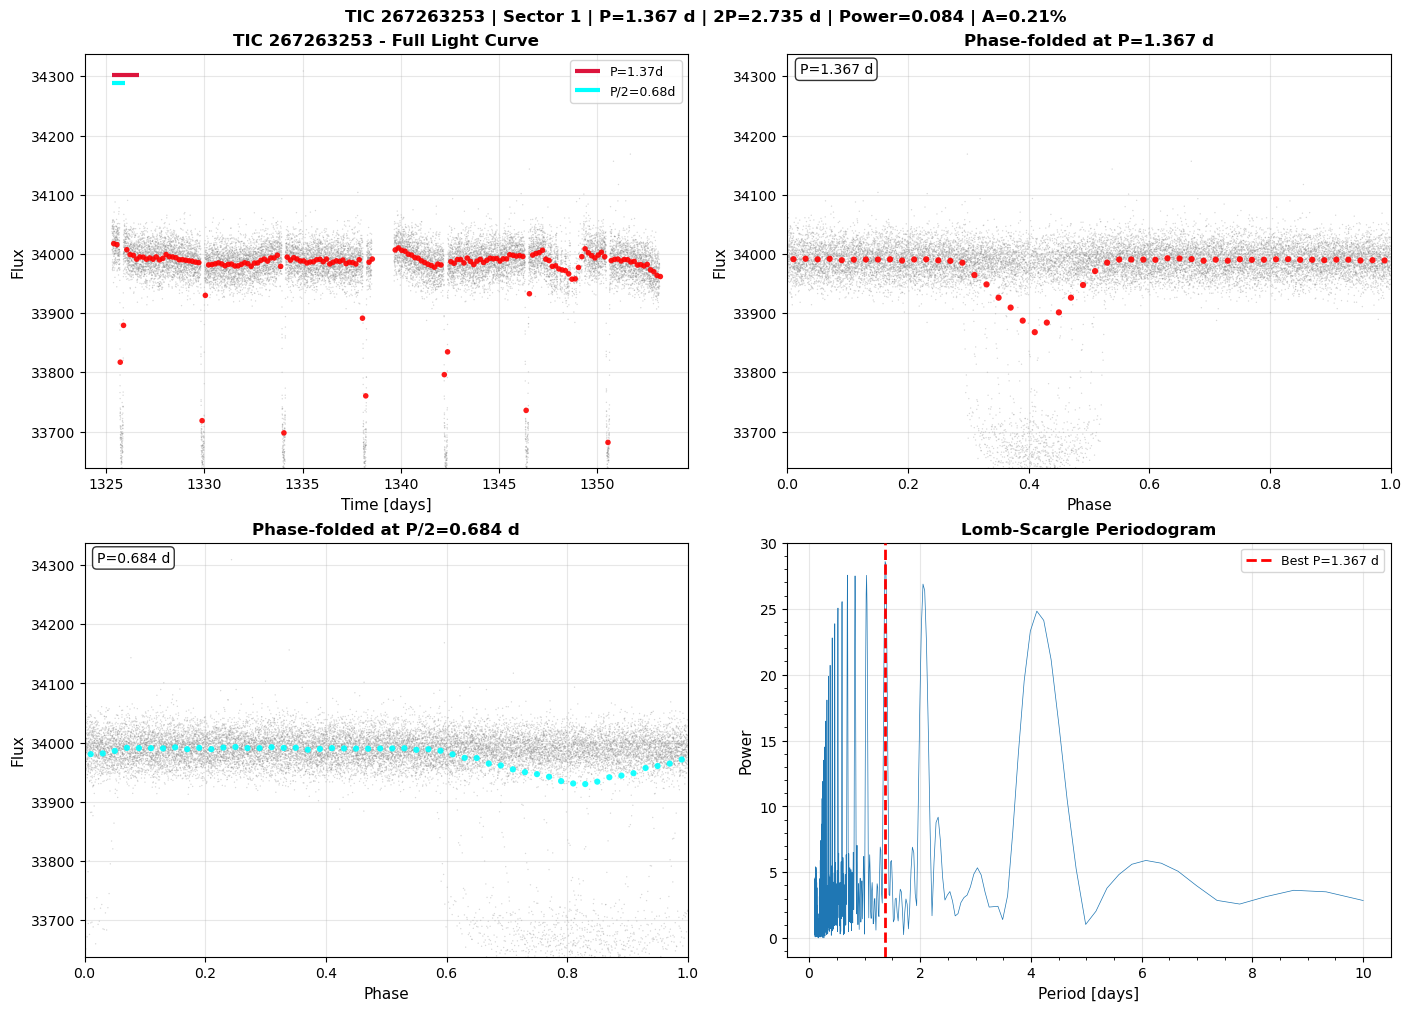

  TIC ID: 251848941
  Sector: 2
  Data points: 18299
  Time range: 1354.11 to 1381.52 days
  Flux range: 10484.52 to 10589.19
  Best period: 6.3139 days
  Max power: 0.0026


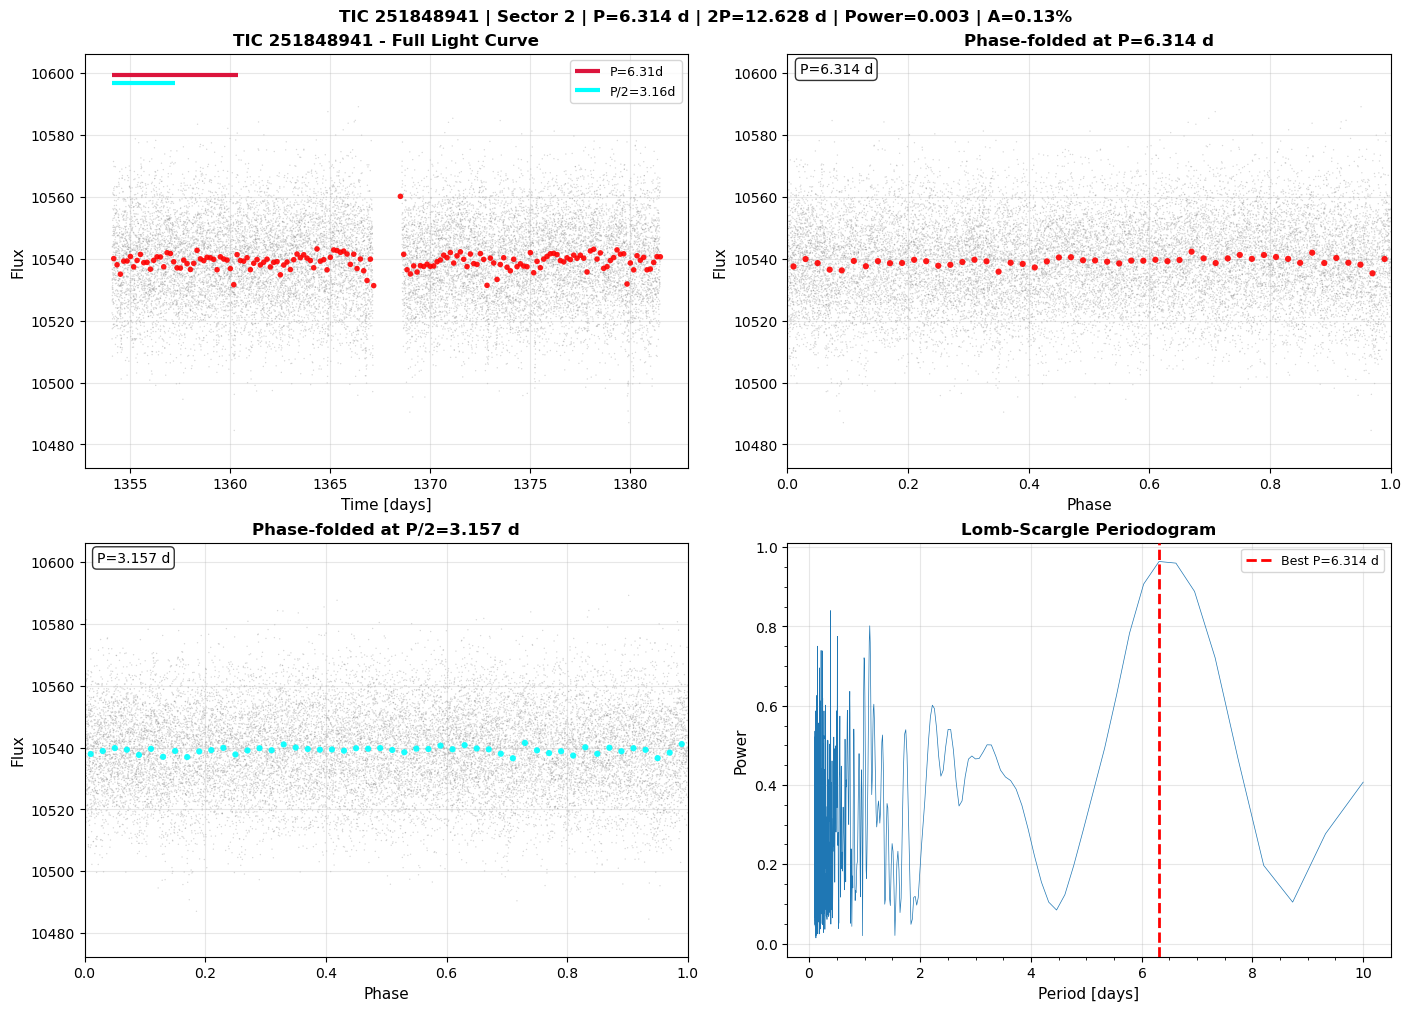

  TIC ID: 261257684
  Sector: 12
  Data points: 11779
  Time range: 1630.19 to 1652.89 days
  Flux range: 6936.27 to 7148.11
  Best period: 8.5023 days
  Max power: 0.0298


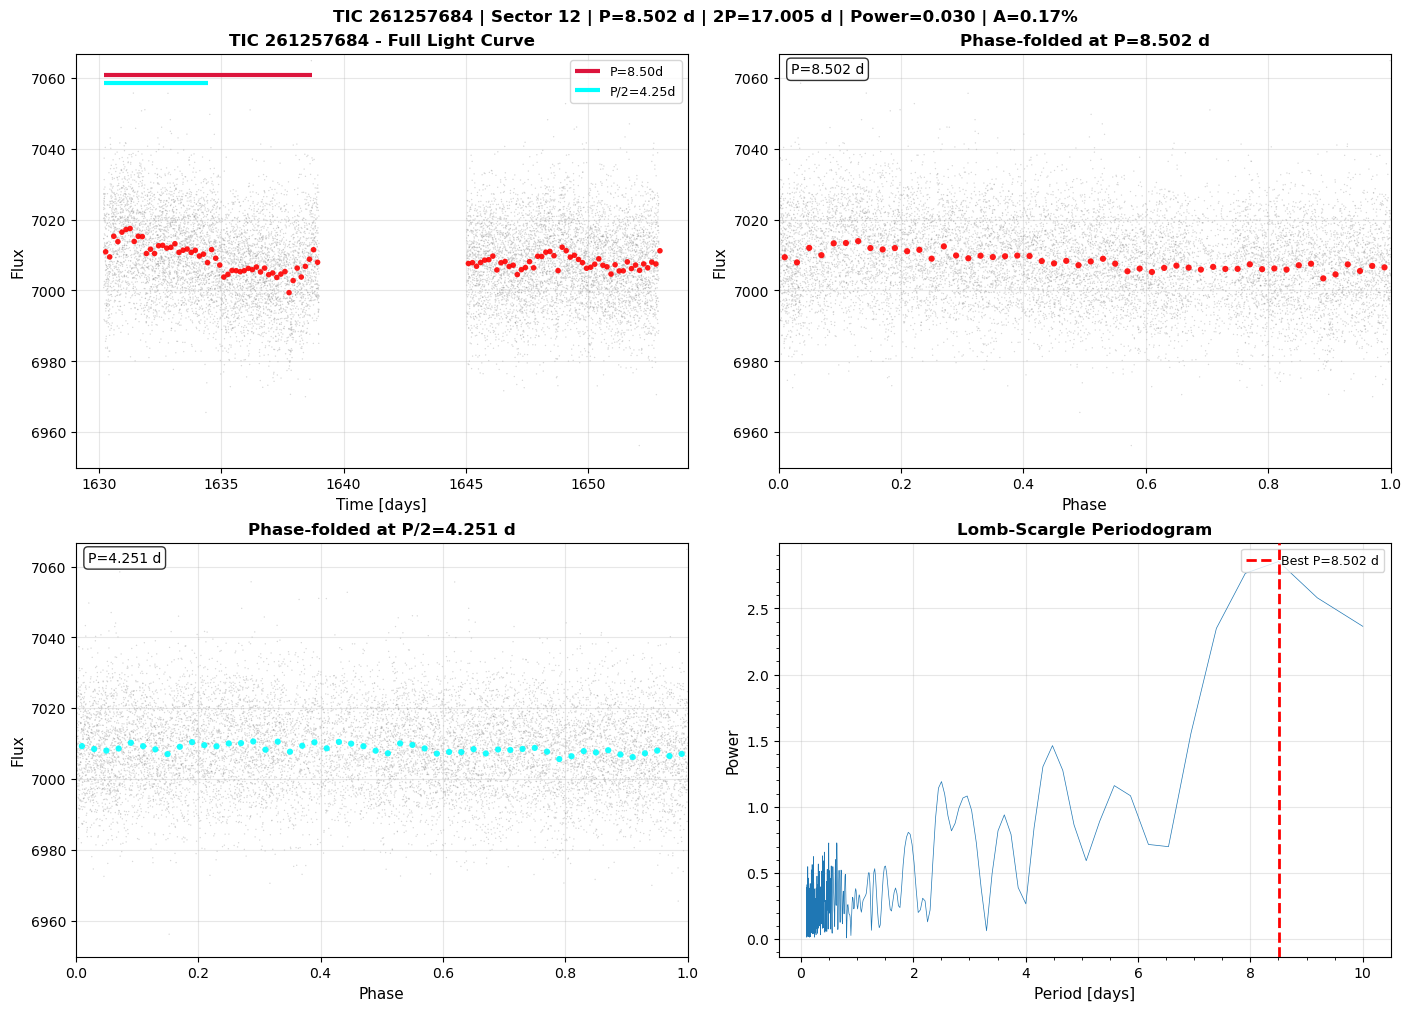

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve
from astropy.timeseries import LombScargle
from pathlib import Path


def _bin_series_fixed_width(x, y, width):
    """Bin data into fixed-width bins along x-axis"""
    if not np.isfinite(width) or width <= 0:
        return np.array([]), np.array([])
    
    x_arr = np.asarray(x, dtype=float)
    y_arr = np.asarray(y, dtype=float)
    
    mask = np.isfinite(x_arr) & np.isfinite(y_arr)
    if not mask.any():
        return np.array([]), np.array([])
    
    x_valid = x_arr[mask]
    y_valid = y_arr[mask]
    x_min = np.nanmin(x_valid)
    x_max = np.nanmax(x_valid)
    
    if not np.isfinite(x_min) or not np.isfinite(x_max):
        return np.array([]), np.array([])
    
    if x_min == x_max:
        edges = np.array([x_min, x_min + width])
    else:
        edges = np.arange(x_min, x_max + width, width)
        if edges.size < 2:
            edges = np.array([x_min, x_max])
    
    return _bin_series_by_edges(x_valid, y_valid, edges)


def _bin_series_by_edges(x, y, edges):
    """Bin data using specified bin edges"""
    x_arr = np.asarray(x, dtype=float)
    y_arr = np.asarray(y, dtype=float)
    mask = np.isfinite(x_arr) & np.isfinite(y_arr)
    
    if not mask.any():
        return np.array([]), np.array([])
    
    x_valid = x_arr[mask]
    y_valid = y_arr[mask]
    inds = np.digitize(x_valid, edges) - 1
    valid = (inds >= 0) & (inds < len(edges) - 1)
    
    if not valid.any():
        return np.array([]), np.array([])
    
    x_valid = x_valid[valid]
    y_valid = y_valid[valid]
    inds = inds[valid]
    
    centers = []
    values = []
    for idx in np.unique(inds):
        bin_mask = inds == idx
        if np.any(bin_mask):
            centers.append(0.5 * (edges[idx] + edges[idx + 1]))
            values.append(np.nanmean(y_valid[bin_mask]))
    
    return np.array(centers), np.array(values)


def _get_flux_ylim(flux_vals):
    """Calculate y-axis limits based on flux statistics"""
    finite_flux = flux_vals[np.isfinite(flux_vals)]
    if finite_flux.size == 0:
        return None
    
    f_med = np.nanmedian(finite_flux)
    f_std = np.nanstd(finite_flux)
    
    if not np.isfinite(f_std) or f_std == 0:
        f_std = 0.01 * abs(f_med) if f_med != 0 else 1.0
    
    return (f_med - 5 * f_std, f_med + 5 * f_std)


def extract_tic_and_sector(fits_path):
    """Extract TIC ID and sector from FITS filename"""
    filename = fits_path.name
    
    # Extract TIC ID (10 digits after 'tess' timestamp)
    # Format: tess<timestamp>-s<sector>-<TIC>-<other>_lc.fits
    parts = filename.split('-')
    
    ticid = None
    sector = None
    
    # Find TIC ID (16-digit number)
    for part in parts:
        if len(part) == 16 and part.isdigit():
            ticid = int(part)
            break
    
    # Find sector (format: s####)
    for part in parts:
        if part.startswith('s') and len(part) == 5:
            try:
                sector = int(part[1:])
            except:
                pass
            break
    
    return ticid, sector


# Find all FITS files
root_dir = Path("/Users/suyuxin/downloads/mastDownload/TESS")
fits_files = sorted(root_dir.rglob("*_lc.fits"))

print(f"Found {len(fits_files)} FITS files")

# Output directory for plots
output_dir = Path("/Users/suyuxin/Downloads/light_curves")
output_dir.mkdir(exist_ok=True)

results = []

# Loop over each FITS file
for i, fits_path in enumerate(fits_files, 1):

    
    try:
        # Read light curve
        lc = lk.read(fits_path)
        time = lc.time.value
        flux = lc.flux.value
        
        # Remove NaNs
        mask = np.isfinite(time) & np.isfinite(flux)
        time = time[mask]
        flux = flux[mask]
        
        if len(time) < 100:
            print(f" Skipping: Too few data points ({len(time)})")
            continue
        
        # Extract TIC ID and sector from filename
        ticid, sector = extract_tic_and_sector(fits_path)
        
        print(f"  TIC ID: {ticid}")
        print(f"  Sector: {sector}")
        print(f"  Data points: {len(time)}")
        print(f"  Time range: {time.min():.2f} to {time.max():.2f} days")
        print(f"  Flux range: {flux.min():.2f} to {flux.max():.2f}")
        
        # Compute periodogram using LombScargle
        frequency, power = LombScargle(time, flux).autopower(
            minimum_frequency=0.1, 
            maximum_frequency=10
        )
        
        best_index = np.argmax(power)
        best_frequency = frequency[best_index]
        best_period = 1 / best_frequency
        max_power = power[best_index]
        
        print(f"  Best period: {best_period:.4f} days")
        print(f"  Max power: {max_power:.4f}")
        
        # Calculate amplitude
        amp = np.nanstd(flux) / np.nanmedian(flux)
        
        # Store results
        results.append({
            "file": fits_path.name,
            "ticid": ticid,
            "sector": sector,
            "best_period_days": best_period,
            "max_power": max_power,
            "amplitude_percent": amp * 100
        })
        
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
        ax_time = axes[0, 0]
        ax_phase = axes[0, 1]
        ax_two_phase = axes[1, 0]
        ax_periodo = axes[1, 1]
        
        # Calculate y-limits
        ylims = _get_flux_ylim(flux)
        
        # PLOT 1: Full time series
        ax_time.scatter(time, flux, s=1, color="0.5", alpha=0.3, edgecolor="none")
        
        bin_width_days = 4.0 / 24.0  # 4 hours
        binned_time, binned_flux = _bin_series_fixed_width(time, flux, bin_width_days)
        if binned_time.size > 0:
            ax_time.scatter(binned_time, binned_flux, s=16, color="red", 
                          alpha=0.9, edgecolor="none", zorder=5)
        
        ax_time.set_xlabel("Time [days]", fontsize=11)
        ax_time.set_ylabel("Flux", fontsize=11)
        ax_time.set_title(f"TIC {ticid} - Full Light Curve", fontsize=12, fontweight='bold')
        ax_time.grid(True, alpha=0.3)
        if ylims:
            ax_time.set_ylim(ylims)
        
        # Add period markers
        if np.isfinite(best_period) and best_period > 0 and ylims:
            y_pos = ylims[1] - 0.05 * (ylims[1] - ylims[0])
            x_start = time.min()
            x_end = x_start + best_period
            ax_time.hlines(y_pos, x_start, x_end, colors="crimson", linewidth=3, 
                          label=f'P={best_period:.2f}d', zorder=10)
            
            x_end_half = x_start + 0.5 * best_period
            ax_time.hlines(y_pos - 0.02*(ylims[1] - ylims[0]), x_start, x_end_half, 
                          colors="cyan", linewidth=3, label=f'P/2={best_period/2:.2f}d', zorder=10)
            ax_time.legend(loc='upper right', fontsize=9)
        
        # PLOT 2: Phase-folded at full period
        if np.isfinite(best_period) and best_period > 0:
            time0 = time.min()
            phase = np.mod(time - time0, best_period) / best_period
            
            ax_phase.scatter(phase, flux, s=1, color="0.5", alpha=0.3, edgecolor="none")
            
            phase_edges = np.linspace(0, 1, 51)
            binned_phase, binned_phase_flux = _bin_series_by_edges(phase, flux, phase_edges)
            if binned_phase.size > 0:
                ax_phase.scatter(binned_phase, binned_phase_flux, s=20, color="red", 
                               alpha=0.9, edgecolor="none", zorder=5)
            
            ax_phase.set_xlim(0, 1)
            ax_phase.text(0.02, 0.98, f"P={best_period:.3f} d", 
                         transform=ax_phase.transAxes, ha="left", va="top", 
                         fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax_phase.text(0.5, 0.5, "No valid period", ha="center", va="center",
                         transform=ax_phase.transAxes, fontsize=12, color='red')
        
        ax_phase.set_xlabel("Phase", fontsize=11)
        ax_phase.set_ylabel("Flux", fontsize=11)
        ax_phase.set_title(f"Phase-folded at P={best_period:.3f} d", fontsize=12, fontweight='bold')
        ax_phase.grid(True, alpha=0.3)
        if ylims:
            ax_phase.set_ylim(ylims)
        
        # PLOT 3: Phase-folded at half period
        period_half = 0.5 * best_period
        if np.isfinite(period_half) and period_half > 0:
            time0 = time.min()
            phase = np.mod(time - time0, period_half) / period_half
            
            ax_two_phase.scatter(phase, flux, s=1, color="0.5", alpha=0.3, edgecolor="none")
            
            phase_edges = np.linspace(0, 1, 51)
            binned_phase, binned_phase_flux = _bin_series_by_edges(phase, flux, phase_edges)
            if binned_phase.size > 0:
                ax_two_phase.scatter(binned_phase, binned_phase_flux, s=20, color="cyan", 
                                   alpha=0.9, edgecolor="none", zorder=5)
            
            ax_two_phase.set_xlim(0, 1)
            ax_two_phase.text(0.02, 0.98, f"P={period_half:.3f} d", 
                             transform=ax_two_phase.transAxes, ha="left", va="top",
                             fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax_two_phase.set_xlabel("Phase", fontsize=11)
        ax_two_phase.set_ylabel("Flux", fontsize=11)
        ax_two_phase.set_title(f"Phase-folded at P/2={period_half:.3f} d", fontsize=12, fontweight='bold')
        ax_two_phase.grid(True, alpha=0.3)
        if ylims:
            ax_two_phase.set_ylim(ylims)
        
        # PLOT 4: Periodogram
        lc_obj = LightCurve(time=time, flux=flux)
        pg = lc_obj.to_periodogram(method='lombscargle', minimum_period=0.1, maximum_period=10)
        
        pg.plot(ax=ax_periodo)
        ax_periodo.set_title('Lomb-Scargle Periodogram', fontsize=12, fontweight='bold')
        ax_periodo.set_xlabel('Period [days]', fontsize=11)
        ax_periodo.set_ylabel('Power', fontsize=11)
        ax_periodo.grid(True, alpha=0.3)
        
        # Add vertical line at detected period
        ax_periodo.axvline(best_period, color='red', linestyle='--', linewidth=2, 
                          label=f'Best P={best_period:.3f} d', zorder=10)
        ax_periodo.legend(loc='upper right', fontsize=9)
        
        # Overall title
        fig.suptitle(
            f"TIC {ticid} | Sector {sector} | P={best_period:.3f} d | 2P={2*best_period:.3f} d | Power={max_power:.3f} | A={amp*100:.2f}%",
            fontsize=12, fontweight='bold'
        )
        
        # Save figure
        output_filename = output_dir / f"TIC{ticid}_sector{sector}_lightcurve.png"
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
       
        plt.show()
        plt.close()
        
    except Exception as e:
        print(f"  Error processing {fits_path.name}: {e}")
        continue


if results:
    # Save results to CSV
    import csv
    
    results_file = output_dir / "period_analysis_results.csv"
    with open(results_file, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)
    